In [647]:
import sys
sys.path.append("..")
from reader import generic_reader

import numpy as np
import pandas as pd

from sklearn.cluster import  MeanShift, estimate_bandwidth
from scipy.spatial.distance import cdist
from sklearn import metrics

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.animation

In [648]:
data = generic_reader.read_csv_file_to_data_frame("movie_data/danish_movies.csv")

In [649]:
data.isnull().sum()

adult                        0
backdrop_path             3175
budget                       0
homepage                  4889
id                           0
imdb_id                   1445
origin_country               0
original_language            0
original_title               0
overview                  1239
popularity                   0
poster_path               1045
production_countries         0
release_date                 0
revenue                      0
runtime                      0
spoken_languages             0
status                       0
tagline                   4825
title                        0
video                        0
vote_average                 0
vote_count                   0
genre_ids                    0
production_company_ids       0
collection_id             4871
cast_person_ids              0
cast_credit_ids              0
crew_person_ids              0
crew_credit_ids              0
dtype: int64

In [ ]:
# Droppping columns which won't be neeeded, delete when merging with cleaned data
columns_to_drop = ['adult', 'backdrop_path', 'homepage', 'id', 'imdb_id', 'origin_country', 'original_language', 'original_title', 
                   'overview', 'poster_path', 'production_countries', 'production_company_ids', 'runtime', 'spoken_languages', 'status', 'tagline', 'title', 
                   'video', 'production_company_ids', 'collection_id', 'cast_credit_ids', 'crew_credit_ids', 'budget', 'revenue', 'vote_count']
data = data.drop(columns=columns_to_drop)

In [651]:
data.head()

,release_date,genre_ids,cast_person_ids,crew_person_ids
0,1897-01-01,[99],[2452695],"[1171313, 1171313]"
1,1897-12-25,[99],[],[1171313]
2,1899-05-20,[99],"[4658231, 4658234]",[1171313]
3,1899-09-02,[99],[],[1171313]
4,1899-11-25,[99],[],[1171313]


In [652]:
data.shape

(5134, 4)

In [ ]:
# Make sure we operate on the same dataframe
# Remove 99 from genre_ids lists
df['genre_ids'] = df['genre_ids'].apply(lambda x: [g for g in x if g != 99])

# One-hot encode remaining genres
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
genre_onehot = mlb.fit_transform(df['genre_ids'])
genre_df = pd.DataFrame(genre_onehot, columns=[f'genre_{g}' for g in mlb.classes_])

# Merge back to the main dataframe
df_encoded = pd.concat([df, genre_df], axis=1)

# Convert release_date to datetime and extract year
df_encoded['release_date'] = pd.to_datetime(df_encoded['release_date'], errors='coerce')
df_encoded['release_year'] = df_encoded['release_date'].dt.year

# Numerical features (use release_year instead of release_date)
numerical_features = ['release_year', 'vote_average', 'popularity']
X_num = df_encoded[numerical_features]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)

# Combine numerical + genre one-hot
import numpy as np
X = np.hstack([X_num_scaled, genre_df.values])


In [654]:
bandwidth = estimate_bandwidth(X, quantile=0.13, n_samples=500)
bandwidth 

np.float64(1.7484897013014178)

In [655]:
msmodel = MeanShift(bandwidth=bandwidth, bin_seeding=True)
msmodel.fit(X)

MeanShift(bandwidth=np.float64(1.7484897013014178), bin_seeding=True)

In [656]:
labels = msmodel.labels_
labels

array([2, 2, 2, ..., 1, 0, 0])

In [657]:


labels_unique = np.unique(labels)
labels_unique



array([0, 1, 2])

In [658]:


n_clusters_ = len(labels_unique)
n_clusters_



3

In [659]:
cluster_centers = msmodel.cluster_centers_
cluster_centers

array([[ 5.47380006e-01, -7.95261746e-01,  0.00000000e+00,
         0.00000000e+00,  4.15800416e-03,  1.81392931e-01,
         1.29937630e-02,  1.09147609e-01,  1.03950104e-03,
         1.09147609e-01,  2.65072765e-02,  1.55925156e-02,
         1.61122661e-01,  2.77546778e-01,  1.00000000e+00,
         1.00000000e+00],
       [ 3.84048696e-01,  1.00674450e+00,  0.00000000e+00,
         0.00000000e+00,  6.68896321e-03,  3.31939799e-01,
         1.08695652e-02,  3.18561873e-01,  0.00000000e+00,
         3.18561873e-01,  1.58862876e-02,  1.00334448e-02,
         3.26923077e-01,  1.80602007e-01,  1.00000000e+00,
         1.00000000e+00],
       [-1.52657758e+00, -7.99532119e-01,  0.00000000e+00,
         0.00000000e+00,  6.61375661e-03,  2.24867725e-01,
         6.61375661e-03,  9.12698413e-02,  0.00000000e+00,
         9.12698413e-02,  2.91005291e-02,  6.61375661e-03,
         2.02380952e-01,  2.32804233e-01,  1.00000000e+00,
         1.00000000e+00]])

In [660]:
Y = msmodel.predict(X)
Y

array([2, 2, 2, ..., 1, 0, 0])

In [661]:


len(msmodel.labels_)



5134

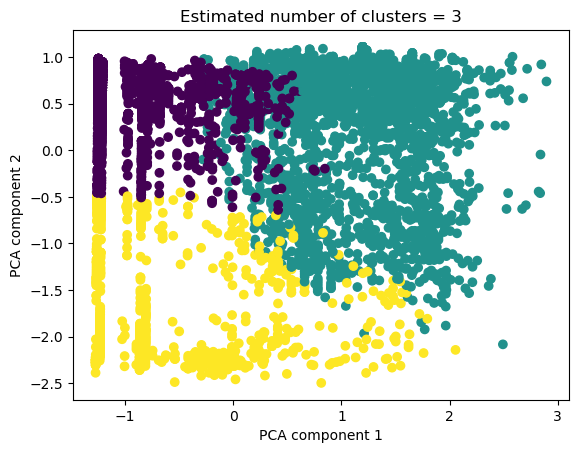

In [662]:
from sklearn.decomposition import PCA

# Reduce X to 2D for visualization
X_2d = PCA(n_components=2).fit_transform(X)

plt.scatter(X_2d[:,0], X_2d[:,1], c=labels, cmap='viridis', marker='o')
plt.title(f'Estimated number of clusters = {n_clusters_}')
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.show()


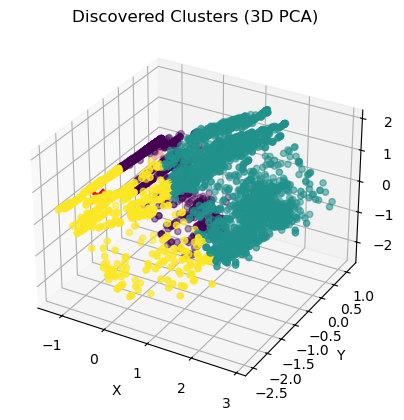

In [663]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Reduce data to 3D
X_3d = PCA(n_components=3).fit_transform(X)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Discovered Clusters (3D PCA)')

# Scatter plot of movies colored by cluster
ax.scatter(X_3d[:,0], X_3d[:,1], X_3d[:,2], c=labels, cmap='viridis', marker='o')

# Transform cluster centers too (important!)
cluster_centers_3d = PCA(n_components=3).fit(X).transform(cluster_centers)
ax.scatter(cluster_centers_3d[:,0], cluster_centers_3d[:,1], cluster_centers_3d[:,2],
           marker='x', color='red', s=100, linewidth=3)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()
